In [6]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize

The `scipy.optimize` module provides numerical tools for solving optimization problems. In this case, we use `scipy.optimize.minimize` to perform Maximum Likelihood Estimation (MLE) for the Vasicek model.

MLE involves finding the parameters (`a`, `b`, and `σ`) that minimize the negative log-likelihood function — a mathematical expression that measures how well the Vasicek model explains the observed data.

Since this function has no closed-form solution, `scipy`'s optimization tools allow us to numerically search for the best parameter values, respecting constraints like positivity and parameter bounds. This enables more flexible and precise estimation than simple regression alone.


In [2]:
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2024, 12, 31)

In [3]:
df = pd.read_csv('GS3M.csv',parse_dates=['observation_date'])
df = df.dropna()

In [4]:
r = df['GS3M'].values / 100

if len(r) < 2:
    raise ValueError("Not enough data points.")

In [5]:
r_t = r[:-1]
r_tp1 = r[1:]
dt = 1 / 250

MLE is a method to estimate the parameters of a model (like a, b, and σ in Vasicek) by finding the values that make the observed data most probable under the model.

Technically, MLE wants to maximize the likelihood function — this is the probability of seeing the data we have, given a set of parameters.

But:

Likelihoods are usually very small numbers, and multiplying many probabilities gets messier.

So instead, we use the log-likelihood (easier math, avoids underflow).

Then, because optimization tools like scipy.optimize.minimize() only minimize, we take the negative of the log-likelihood.

maximize log-likelihood  →  minimize negative log-likelihood (can't directly maximise on pyhton)


The model says:

Given today's interest rate, and a set of parameters a, b, σ,
here's where the next interest rate should be most likely to fall (mean μ) and how uncertain it is (variance Q).
Now you:

Guess values for a, b, and σ
Compute how likely the actual data is under those guesses using the Vasicek likelihood formula.
Tweak the parameters until you find the ones that make the data most probable.


In [7]:
def vasicek_neg_log_likelihood(params):
    a, b, sigma = params
    if a <= 0 or sigma <= 0:
        return np.inf
    phi = np.exp(-a * dt)
    mu = r_t * phi + b * (1 - phi)
    Q = (sigma ** 2) * (1 - phi ** 2) / (2 * a)
    ll = -0.5 * np.sum(np.log(2 * np.pi * Q) + ((r_tp1 - mu) ** 2)/ Q)
    return -ll

📘 Log-Likelihood in the Vasicek Model

In the Vasicek model, we assume that the next interest rate `r_{t+1}` is normally distributed, given today's rate `r_t`. That means:

> `r_{t+1}` | `r_t` ~ Normal(mean = μ, variance = Q)

The mean (`μ`) and variance (`Q`) depend on the Vasicek parameters:

- `phi = exp(-a * dt)` — how much today's rate carries over
- `mu = r_t * phi + b * (1 - phi)` — the expected value of `r_{t+1}`
- `Q = (sigma^2 * (1 - phi^2)) / (2 * a)` — the variance of `r_{t+1}`

For each time step, the log-likelihood of observing `r_{t+1}` is:

log L = -0.5 * [ log(2πQ) + ((r_{t+1} - mu)^2) / Q ]

To compute the total log-likelihood, we sum this expression across all time steps.

In practice, we:
- Use this formula to compare how well different parameter guesses (`a`, `b`, `sigma`) explain the data
- Take the negative of the log-likelihood so it can be minimized using an optimizer like `scipy.optimize.minimize`

This forms the basis of Maximum Likelihood Estimation (MLE) for fitting the Vasicek model.

In [8]:
initial_guess = [0.1, 0.02, 0.01]
bounds = [(1e-5, 5), (-0.1, 0.2), (1e-6, 1)]

Starting guesses for the parameters: a, b and sigma.

The bounds show the range in which the parameters must stay between during optimisation.

In [9]:
result = minimize(vasicek_neg_log_likelihood , initial_guess , bounds=bounds)
if not result.success:
    raise RuntimeError("MLE optimization failed: " + result.message)

minimize() function automatically searches through parameter space and finds the a, b, and σ that make your model fit the observed data as well as possible — based on probability.

After attempting the optimisation, this checks whether it was successful. If it wasn’t, it raises an error and shows the reason why, using result.message.

In [11]:
a_mle , b_mle , sigma_mle = result.x

print("MLE Estimated Vasicek Parameters:")
print(f"a (speed of mean reversion) = {a_mle:.6f}")
print(f"b (long-term mean rate) = {b_mle:.6f}")
print(f"sigma (instantaneous volatility) = {sigma_mle:.6f}")

MLE Estimated Vasicek Parameters:
a (speed of mean reversion) = 4.583946
b (long-term mean rate) = 0.026455
sigma (instantaneous volatility) = 0.048903


result.x contains the exact [a, b, σ] that produced the lowest value of your function.
That's why we extract them as the "best-fit" parameters:

These print lines simply print the estimated parameters, formatted to 6 decimal places.

In [13]:
a = a_mle
b = b_mle
sigma = sigma_mle

simulated_rates = [r[0]]  # Starting simulation at the first actual interest rate
np.random.seed(42)

for _ in range(len(r) - 1):
    r_prev = simulated_rates[-1]
    drift = a * (b - r_prev) * dt
    shock = sigma * np.sqrt(dt) * np.random.normal()
    r_next = r_prev + drift + shock
    simulated_rates.append(r_next)


Generating a realistic future path of interest rates using the continuous-time Vasicek model, calibrated with the MLE estimates of the parameters

The Vasicek model is:

dr(t) = a(b − r(t))dt + σdW(t)

The parameters are:

a: speed of mean reversion

b: long-term mean level

σ: volatility of the process

dWt: Brownian motion term (random noise)

Since we're simulating this in code, we discretize the model:

r_{t+1} = r_{t} + a(b − r_{t})Δt + (σ(Δt)^1/2 )⋅ε_{t}

Where:

dt is the time step (we use 1/250 to reflect daily observations)

ε_{t} ∼N(0,1) is a standard normal random draw


Each step represents 1 trading day. For every day:

- r_prev: Get the previous simulated rate
- drift: The deterministic pull toward the long-term mean
   - This is the mean-reversion component
- shock: Add a random noise term from a normal distribution
   - This is the stochastic/random component
- r_next: Combine them to get the new simulated rate
- r_next = r_prev + drift + shock
- Append it to the list to continue the path

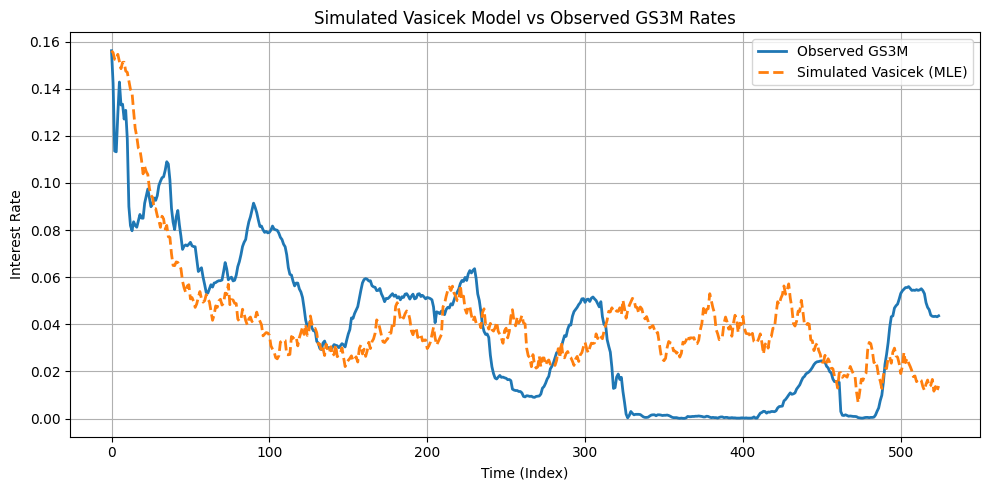

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(r, label="Observed GS3M", linewidth=2)
plt.plot(simulated_rates, label="Simulated Vasicek (MLE)", linestyle='--', linewidth=2)
plt.title("Simulated Vasicek Model vs Observed GS3M Rates")
plt.xlabel("Time (Index)")
plt.ylabel("Interest Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
estimates_df = pd.DataFrame({
    'a': [a_mle],
    'b': [b_mle],
    'sigma': [sigma_mle]
})

# Save as CSV
csv_path = "vasicek_mle_estimates.csv"
estimates_df.to_csv(csv_path, index=False)
print(f"CSV saved to: {csv_path}")

# Save as .npz
npz_path = "vasicek_mle_params.npz"
np.savez(npz_path, a=a_mle, b=b_mle, sigma=sigma_mle)
print(f"NumPy parameters saved to: {npz_path}")

CSV saved to: vasicek_mle_estimates.csv
NumPy parameters saved to: vasicek_mle_params.npz
